In [1]:
import win32gui
import win32api
import win32con
import pickle
import glob
import time

import random as rd
from random import randint, uniform, sample, seed

import tensorflow as tf
import numpy as np

from PIL import Image, ImageDraw, ImageGrab
from skimage import io

from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D 
from keras.models import Model, load_model

import keras.backend as K

import matplotlib.pyplot as plt
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['uniform', 'sample', 'seed', 'randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Вспомогательные и тестовые функции

In [2]:
def callback(hwnd, extra):
    """
    Detects position and size of the Vysor application window
    Example copied from Stackoverflow
    Input:
    - hwnd: unknown
    - extra: nothing
    Output: nothing
    """
    rect = win32gui.GetWindowRect(hwnd)
    x = rect[0]
    y = rect[1]
    w = rect[2] - x
    h = rect[3] - y
    
    win_name = win32gui.GetWindowText(hwnd)
    
    if (win_name == "FRD L19"):
        print("Window %s:" % win_name)
        print("\tLocation: (%d, %d)" % (x, y))
        print("\t    Size: (%d, %d)" % (w, h))
        
        if ((x >= 0) and (y >= 0)):
            start_box_left_top_x = x + 260
            start_box_left_top_y = y + 680

            start_box_right_bottom_x = start_box_left_top_x + 45
            start_box_right_bottom_y = start_box_left_top_y + 55

            #h_x, h_y = win32api.GetCursorPos()
            #print(h_x, h_y)

            #im = pyscreenshot.grab(bbox=(start_box_left_top_x, start_box_left_top_y, start_box_right_bottom_x, start_box_right_bottom_y))
            #im.show()
            #im.save("GameStarter.png")

win32gui.EnumWindows(callback, None)

### Основные функции

In [3]:
# Окно приложения, левый верхний угол: 663 0
# Центр блюда в ряду 1, колонке 1: 727 350

def fix_window_coordinates_and_size(window_name, use_external_screen=True):
    """
    Returns coordinates of the left top corner of the window
    Input:
    - window_name: target window name, string
    Output:
    - x: x coordinate, int
    - y: y coordinate, int
    - w: window width (over the X axis)
    - h: window height (over the Y axis)
    """
    
    # Get window handle
    win_handle = win32gui.FindWindow(None, window_name)
    
    assert win_handle, "Window not found!"

    # Get window coordinates
    rect = win32gui.GetWindowRect(win_handle)
    x = rect[0]
    y = rect[1]
    w = rect[2] - x
    h = rect[3] - y

    if (use_external_screen):
        win32gui.MoveWindow(win_handle, 600, 0, 380, 760, True)
        result = (600, 0, 380, 760)
    else:
        win32gui.MoveWindow(win_handle, 900, 0, 380, 760, True)
        result = (900, 0, 380, 760)
    
    return result


def check_if_new_game(x, y, parameters):
    """
    Checks if there is a new game screen with the start new game triangle
    Input:
    - x: left top corner x coordinate of the application, int
    - y: left top corner y coordinate of the application, int
    - parameters: dict with parameters incl. Game_Starter ethalon box, dict
    Output:
    - result: boolean. True if there is a new game screen, False otherwise
    """

    # Get part of the window, where the game starter circle/triangle is expected
    game_starter = ImageGrab.grab(bbox=(x + 172, y + 481, x + 209, y + 519))
    game_starter = game_starter.convert("L")
    game_starter = np.array(game_starter)
    
    # Load ethalon game starter box
    ethalon = parameters["Game_Starter"]
    
    # Check them
    tmp2 = np.abs(game_starter.astype(int) - ethalon.astype(int))
    difference = tmp2.sum()    
    
    if (difference < 300.):
        print("We can start a new game")
        result = True
    else:
        print("Game is progress, difference =", difference)
        result = False
    
    return result


def press_start(x, y):
    """
    Presses the Start New Game triangle
    Input:
    - x: top left corner x coordinate of the window, int
    - y: top left corner y coordinate of the window, int
    Output:
    - True
    """

    x_res = win32api.GetSystemMetrics(0)
    y_res = win32api.GetSystemMetrics(1)
    
    start_x = x + 172 + 19
    start_y = y + 481 + 19
    
    nx = int(start_x * 65535 / x_res)
    ny = int(start_y * 65535 / y_res)
    
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_MOVE, nx, ny, 0, 0)
    win32api.Sleep(200)
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_LEFTDOWN, nx, ny, 0, 0)
    win32api.Sleep(200)
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_LEFTUP, nx, ny, 0, 0)
    win32api.Sleep(500)
    
    return True


def press_next_game(x, y):
    """
    Presses the Play Again button
    Input:
    - x: top left corner x coordinate of the window, int
    - y: top left corner y coordinate of the window, int
    Output:
    - True
    """

    x_res = win32api.GetSystemMetrics(0)
    y_res = win32api.GetSystemMetrics(1)
    
    start_x = x + 180
    start_y = y + 480
    
    nx = int(start_x * 65535 / x_res)
    ny = int(start_y * 65535 / y_res)
    
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_MOVE, nx, ny, 0, 0)
    win32api.Sleep(200)
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_LEFTDOWN, nx, ny, 0, 0)
    win32api.Sleep(200)
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_LEFTUP, nx, ny, 0, 0)
    win32api.Sleep(500)
    
    return True


def get_1_digit_score(score, parameters):
    """
    Extracts one digit score (3-9)
    Input:
    - score: PIL Image with the score
    - parameters: dict with parameters incl. ethalon digits, dict
    Output:
    - score, positive if score found, int. -1 otherwise.
    """
    # Load ethalon large digits
    ethalon_single = parameters["Ethalon_Single"]
    
    # Crop the digit
    digit = np.array(score.crop((13, 9, 23, 25)))    
    
    # Find the best possible ethalon digit
    tmp2 = np.abs(digit.astype(int) - ethalon_single.astype(int))
    result = tmp2.sum(axis=(1, 2))
    
    if (np.min(result) > 500.):
        choice = -1
    else:
        choice = np.argmin(result)    
    
    return choice


def get_2_digits_score(score, parameters):
    """
    Extracts two digits score (xx)
    Input:
    - score: PIL Image with the score
    - parameters: dict with parameters incl. ethalon digits, dict
    Output:
    - score, positive if score found, int. -1 otherwise.
    """
    
    # Load ethalon large digits
    ethalon_large_left = parameters["Ethalon_Large_Left"]
    ethalon_large_right = parameters["Ethalon_Large_Right"]

    # Crop the digits
    left_digit = np.array(score.crop((6, 9, 16, 25) ))
    right_digit = np.array(score.crop((19, 9, 29, 25)))
    
    # Find the best possible left ethalon digit
    tmp2 = np.abs(left_digit.astype(int) - ethalon_large_left.astype(int))
    result = tmp2.sum(axis=(1, 2))
    
    if (np.min(result) > 500.):
        return -1
    
    left_choice = np.argmin(result)
    
    # Find the best possible right ethalon digit
    tmp2 = np.abs(right_digit.astype(int) - ethalon_large_right.astype(int))
    result = tmp2.sum(axis=(1, 2))
    
    right_choice = np.argmin(result)
    
    return left_choice*10 + right_choice


def get_3_digits_score(score, parameters):
    """
    Extracts three digits score (xxx)
    Input:
    - score: PIL Image with the score
    - parameters: dict with parameters incl. ethalon digits, dict
    Output:
    - score, positive if score found, int. -1 otherwise.
    """
    # Load ethalon large digits
    ethalon_small_left = parameters["Ethalon_Small_Left"]
    ethalon_small_middle = parameters["Ethalon_Small_Middle"]
    ethalon_small_right = parameters["Ethalon_Small_Right"]
    
    # Crop the digits
    left_digit = np.array(score.crop((4, 12, 12, 23)))
    middle_digit = np.array(score.crop((14, 12, 22, 23)))
    right_digit = np.array(score.crop((23, 12, 31, 23)))
    
    # Find the best possible left ethalon digit
    tmp2 = np.abs(left_digit.astype(int) - ethalon_small_left.astype(int))
    result = tmp2.sum(axis=(1, 2))
    
    if (np.min(result) > 500.):
        return -1
    
    left_choice = np.argmin(result)
    
    # Find the best possible middle ethalon digit
    tmp2 = np.abs(middle_digit.astype(int) - ethalon_small_middle.astype(int))
    result = tmp2.sum(axis=(1, 2))
    middle_choice = np.argmin(result)
    
    # Find the best possible right ethalon digit
    tmp2 = np.abs(right_digit.astype(int) - ethalon_small_right.astype(int))
    result = tmp2.sum(axis=(1, 2))
    right_choice = np.argmin(result)
    
    return left_choice*100 + middle_choice*10 + right_choice


def get_current_score(x, y, parameters):
    """
    Gets current score. Wrapper for calls to get_1_digit_score, get_2_digits_score, get_3_digits_score
    Input:
    - x: top left corner x coordinate of the application
    - y: top left corner y coordinate of the application
    - parameters: dict with parameters incl. ethalon digits, dict
    Output:
    - score, int
    """
    
    # Get the score plate
    img_score = ImageGrab.grab(bbox=(x + 269, y + 654, x + 304, y + 689))
    img_bw = img_score.convert("L")
    
    # Get the score based on the number of digits
    three_digits_score = get_3_digits_score(img_bw, parameters)
    
    if (three_digits_score == -1):
        two_digits_score = get_2_digits_score(img_bw, parameters)
        
        if (two_digits_score == -1):
            score = get_1_digit_score(img_bw, parameters)
        else:
            score = two_digits_score
    else:
        score = three_digits_score
    
    return score


def process_move_142(move):
    """
    There are total 142 possible moves:
    - along the vertical axis: 6 + 5*12 + 6 = 6*12 = 72
    - along the norizontal axis: 7 + 4*14 + 7 = 5*14 = 70
    
    The _move_ parameter:
    Vertical moves:
    move in 1-6: row 1, column _move_, down
    move in 7-66: row (move - 7 // 12) + 2, column (((move - 7) % 12) // 2) + 1, direction _move_ % 2 == 0 - up, otherwise - down
    move in 67-72: row 7, column (move - 66), up
    
    Horizontal moves:
    move in 73-79: row (move - 72), column 1, right
    move in 80-135: row ((move - 80) % 14) // 2 + 1, column ((move - 80) // 14) + 2, direction _move_ % 2 == 0 - left, otherwise - right
    move in 136-142: row (move - 135), column 6, left    
    
    Input:
    - move: move code, 1-142, int
    Output:
    - row: row where the moved object located, 1-7, int
    - column: row where the moved object located, 1-6, int
    - direction: "up"/"down"/"left"/"right", string
    """
    # Process move
    if (move in range(1, 7)):
        row = 1
        column = move
        direction = "down"
    elif (move in range(7, 67)):
        row = ((move - 7) // 12) + 2
        column = (((move - 7) % 12) // 2) + 1
        direction = "up" if (move % 2 == 0) else "down"
    elif (move in range(67, 73)):
        row = 7
        column = move - 66
        direction = "up"
    elif (move in range(73, 80)):
        row = move - 72
        column = 1
        direction = "right"
    elif (move in range(80, 136)):
        row = (((move - 80) % 14) // 2) + 1
        column = ((move - 80) // 14) + 2
        direction = "left" if (move % 2 == 0) else "right"
    else:
        row = move - 135
        column = 6
        direction = "left"
    
    return row, column, direction


def process_move_71(move):
    """
    There are total 71 possible moves:
    - along the vertical axis: 6*6 = 36
    - along the horizontal axis: 7*5 = 35
    - Total 35 + 36 = 71
    
    The _move_ parameter:
    Vertical moves:
    move in 1-36: row (move - 1) % 6 + 1, column (move - 1) // 6 + 1, "down"
    
    Horizontal moves:
    move in 37-71: row (move - 37) // 5 + 1, column (move - 37) % 5 + 1, "right"
    
    Input:
    - move: move code, 1-66, int
    Output:
    - row: row where the moved object located, 1-7, int
    - column: row where the moved object located, 1-6, int
    - direction: "down"/"right", string
    """
    # Process move
    if (move in range(1, 37)):
        row = (move - 1) % 6 + 1
        column = (move - 1) // 6 + 1
        direction = "down"
    else:
        # move in 37-71
        column = (move - 37) % 5 + 1
        row = (move - 37) // 5 + 1
        direction = "right"
    
    return row, column, direction


def make_move(x, y, number_of_moves, move):
    """
    Physically moves plates: clicks on one plate and drags it in a certain direction
    Input:
    - x, y: application window coordinates, int
    - number_of_moves: either 71 or 142
    - move: particular move to make. Either 1<=move<=71, or 1<=move<=142
    """
    if (number_of_moves == 142):
        row, column, direction = process_move_142(move)
    else:
        row, column, direction = process_move_71(move)
    
    plate_size = 58
    first_plate_center_x = x + 18 + 29
    first_plate_center_y = y + 229 + 29
    
    horizontal_margin = 0
    vertical_margin = 4

    start_x = first_plate_center_x + (column - 1)*(plate_size + horizontal_margin)
    start_y = first_plate_center_y + (row - 1)*(plate_size + vertical_margin)
    
    if (direction == "down"):
        end_x = start_x
        end_y = start_y + plate_size + vertical_margin
    elif (direction == "up"):
        end_x = start_x
        end_y = start_y - plate_size - vertical_margin
    elif (direction == "left"):
        end_x = start_x - plate_size - horizontal_margin
        end_y = start_y 
    else:
        end_x = start_x + plate_size + horizontal_margin
        end_y = start_y 

    # Now handle the mouse (drag with the left button pressed)
    x_res = win32api.GetSystemMetrics(0)
    y_res = win32api.GetSystemMetrics(1)
    
    nx = int(start_x * 65535 / x_res)
    ny = int(start_y * 65535 / y_res)
    
    n_x_dist = int((end_x - start_x) * 65535 / x_res)
    n_y_dist = int((end_y - start_y) * 65535 / y_res)
    
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_MOVE, nx, ny, 0, 0)
    win32api.Sleep(300)
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_LEFTDOWN, nx, ny, 0, 0)
    win32api.Sleep(150)
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_MOVE, nx + n_x_dist, ny + n_y_dist, 0, 0)
    win32api.Sleep(150)
    win32api.mouse_event(win32con.MOUSEEVENTF_ABSOLUTE | win32con.MOUSEEVENTF_LEFTUP, nx + n_x_dist, ny + n_y_dist, 0, 0)
    win32api.Sleep(300)
        
    return


#
# Pixelization v3.0 Full Scale (including bonus plates detection)
# Готовим четырехмерный массив размера 7x6x4, состоящий из 12 классов [red 0-2, green 3-5, blue 6-8, purple 9-11]
# Первый класс - обычное людо, второй класс - премиальное из 4 блюд, третий класс - премиальное из 5ти.
# Массив цветов в таком порядке: [red, green, blue, purple]
# по принципу RGB+Purple
#
def pixelization_v3(x, y, recon=None):
    """
    Converts picture with plates into 4D matrix [7, 6, 4]
    Input:
    - x: top left corner x coordinate of the application
    - y: top left corner y coordinate of the application
    - recon: CNN which will detect color and type
    Output:
    - np.array, shape = [7, 6, 4]
    """
    
    plate_size = 58
    horizontal_margin = 0
    vertical_margin = 4
    
    result = np.zeros((7, 6, 4))
    tmp = []
    
    # Get part of the image with plates in a form of 3D matrix
    all_plates = np.array( ImageGrab.grab(bbox=(x + 18, y + 229, x + 361, y + 658)) )
    
    for ii in range(7):
        for jj in range(6):
            start_x = jj*(plate_size - 1)
            start_y = ii*(plate_size + vertical_margin) - 1*int(bool(ii))
            end_x = plate_size + jj*(plate_size - 1)
            end_y = plate_size + ii*(plate_size + vertical_margin) - 1*int(bool(ii))
            
            plate = all_plates[start_y:end_y, start_x:end_x, :]
            
            tmp.append(plate)
            
    cls = recon.predict(np.stack(tmp, axis=0))
    
    for ii in range(7):
        for jj in range(6):
            predicted_class = np.argmax( cls[ii*6 + jj, :] )
            result[ii, jj, predicted_class // 3] = (predicted_class % 3) + 1
    
    return result


def Aero_CNN_v5(input_shape = (7, 6, 4)):
    """
    Keras CNN
    INPUT -> CONV -> RELU -> CONV -> RELU -> FC -> RELU -> OUTPUT
    """
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    #X = ZeroPadding2D((2, 2))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(128, (3, 3), strides = (1, 1), padding='same', name = 'conv0')(X_input)
    X = Activation('relu')(X)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (3, 3), strides = (1, 1), padding='same', name = 'conv1')(X)
    X = Activation('relu')(X)
    
    # FLATTEN X (means convert it to a vector) + FC + RELU
    X = Flatten()(X)
    X = Dense(64, name='fc0')(X)
    X = Activation('relu')(X)
    
    # FULLYCONNECTED
    X = Dense(16, name='fc1')(X)
    X = Activation('relu')(X)
    
    # FULLYCONNECTED
    X = Dense(1, name='fc2')(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='Aero_CNN')

    return model


def swap_two_plates(field, move):
    """
    Virtually moves two plates according to the move
    Input:
    - field: main matrix of the plates, numpy array, [7, 6, 4]
    - move: particular move to make, int, 1<=move<=142
    Output:
    - new field, numpy array, [7, 6, 4]
    """
    # Process the move from number to coordinates/direction
    row, column, direction = process_move_142(move)    
    
    # Update row/column to start from 0, as they come as 1..7, 1..6
    row = row - 1
    column = column - 1
    
    # Swap two neighbor plates
    tmp = np.array(field[row, column, :])
    
    if (direction == "down"):
        field[row, column, :] = field[row + 1, column, :]
        field[row + 1, column, :] = tmp
    elif (direction == "up"):
        field[row, column, :] = field[row - 1, column, :]
        field[row - 1, column, :] = tmp
    elif (direction == "left"):
        field[row, column, :] = field[row, column - 1, :]
        field[row, column - 1, :] = tmp 
    else:
        field[row, column, :] = field[row, column + 1, :]
        field[row, column + 1, :] = tmp 

    return field


def predict_max_score(field, aero_cnn, number_of_moves):
    """
    TODO
    """
    X_data = ()
    
    for move in range(number_of_moves):
        plates = np.array(field)
        X_data = X_data + ( swap_two_plates(plates, move + 1), )
        
    X_data = np.stack(X_data, axis=0)
    
    prediction = aero_cnn.predict(X_data)
    
    return prediction.max(), prediction.argmax() + 1

### Main program body

#### Эталонные параметры
Размер окна, чтобы работало на ноутбуке:  
  width = 380  
  height = 760  
  
Положение треугольника Game Starter:  
x + 172, y + 481, x + 209, y + 519  
  
Положение счёта:  
x + 269, y + 654, x + 304, y + 689

Двухзначный счет:  
- левая цифра: (6, 9, 16, 25)  
- правая цифра: (19, 9, 29, 25)  

Однозначный счет:
- цифра: (13, 9, 23, 25)  

Трехзначный счет:
- левая цифра: (4, 12, 12, 23)  
- средняя цифра: (14, 12, 22, 23)  
- правая цифра: (23, 12, 31, 23)  

Тарелки:  
- размер: 58x58  
- x центра первой тарелки: x + 18 + 29
- y центра второй тарелки: y + 229 + 29
- горизонтальная маржа: 0
- вертикальная маржа: 4


In [4]:
# Initialize parameters
parameters = {}

# Game Starter
parameters["Game_Starter"] = np.array(Image.open("Game_Starter.png"))

# Ethalon Single Digit
tmp = []

for f in glob.glob("Ethalon_Single\\S*.png"):
    img = io.imread(f)
    tmp.append(img)
    parameters["Ethalon_Single"] = np.array(tmp)
    
# Ethalon Large Digits
tmp = []

for f in glob.glob("Ethalon_Large\\L*.png"):
    img = io.imread(f)
    tmp.append(img)

parameters["Ethalon_Large_Left"] = np.array(tmp)

tmp = []
    
for f in glob.glob("Ethalon_Large\\R*.png"):
    img = io.imread(f)
    tmp.append(img)

parameters["Ethalon_Large_Right"] = np.array(tmp)

# Ethalon Small Digits
tmp = []

for f in glob.glob("Ethalon_Small\\L*.png"):
    img = io.imread(f)
    tmp.append(img)

parameters["Ethalon_Small_Left"] = np.array(tmp)

tmp = []

for f in glob.glob("Ethalon_Small\\M*.png"):
    img = io.imread(f)
    tmp.append(img)

parameters["Ethalon_Small_Middle"] = np.array(tmp)

tmp = []

for f in glob.glob("Ethalon_Small\\R*.png"):
    img = io.imread(f)
    tmp.append(img)

parameters["Ethalon_Small_Right"] = np.array(tmp)

# Load ethalon colors: RGB+Purple
with open('colors.pickle', 'rb') as f:
    colors = pickle.load(f)
    
parameters["Ethalon_Colors"] = colors

# Load ethalon CNN color+plate_type recognizer
recon = load_model('Recognizer_v1.h5')

In [5]:
#
# Выравниваем приложение на экране
#
aeroflot_x, aeroflot_y, aeroflot_width, aeroflot_height = fix_window_coordinates_and_size("FRD L19", use_external_screen=True)

assert ((aeroflot_width == 380) and (aeroflot_height == 760)), print("Incorrect window size!")


In [5]:
# Тут будем хранить историю
#replay_memory = []
with open('replay_memory_4D.pickle', 'rb') as f:
    replay_memory = pickle.load(f)

# Число возможных ходов
number_of_moves = 142

In [6]:
# Загрузим ранее созданную модель
aero_cnn = load_model('AeroCNN_v5.h5')

In [7]:
# Количество предсказаний
total_num_of_predictions = 0
num_of_successful_predictions = 0

In [216]:
# Готовим модель
#aero_cnn = Aero_CNN_v5(input_shape=(7, 6, 4))
#aero_cnn.compile(optimizer='adam', loss='mean_absolute_error')

In [10]:
# Максимальный размер памяти
max_memory_size = 50000

# Вероятность выбора случайного хода
epsilon = 0.85

# Размер минибатча
minibatch = 32

# Пенальти за будущие ходы
gamma = 0.1

# Основной цикл, в котором играем 10 игр
for game in range(10):
    if (check_if_new_game(aeroflot_x, aeroflot_y, parameters)):
        # Press the Start New Game button
        press_start(aeroflot_x, aeroflot_y)
        win32api.Sleep(1000)
    else:
        print("Something is wrong. Exiting...")
        break

    # Делаем 50 ходов. Последний ход нужно будет обработать отдельно. С ним есть нюанс
    moves_left = 50
    game_score = 0
    reward = 0

    # Взбодрим генератор случайных чисел
    rd.seed()

    # Делаем 50 ходов
    while (moves_left > 0):
        # Смотрим картинку перед ходом
        s_before = pixelization_v3(aeroflot_x, aeroflot_y, recon)

        # Выбираем ход
        prob = rd.uniform(0, 1)

        if (prob > epsilon):
            # Будем делать неслучайный ход
            if (total_num_of_predictions == 50):
                print(">>> Successful predictions ratio:", num_of_successful_predictions / total_num_of_predictions)
                total_num_of_predictions = 0
                num_of_successful_predictions = 0
            
            wise_move_debug_flag = 1
            plates = np.array(s_before)
            wise_pred, move = predict_max_score(plates, aero_cnn, number_of_moves)
            total_num_of_predictions = total_num_of_predictions + 1
        else:
            # Случайный ход
            wise_move_debug_flag = 0
            move = rd.randint(1, number_of_moves)

        # Делаем собственно ход
        make_move(aeroflot_x, aeroflot_y, number_of_moves, move)

        if (moves_left > 1):
            picture_1 = pixelization_v3(aeroflot_x, aeroflot_y, recon)
            win32api.Sleep(1000)
            picture_2 = pixelization_v3(aeroflot_x, aeroflot_y, recon)

            while (np.array_equal(picture_1, picture_2) == False):
                picture_1 = pixelization_v3(aeroflot_x, aeroflot_y, recon)
                win32api.Sleep(500)
                picture_2 = pixelization_v3(aeroflot_x, aeroflot_y, recon)

            # Определяем очки за ход - результат хода
            current_score = get_current_score(aeroflot_x, aeroflot_y, parameters)

            if (current_score != -1):
                if ((game_score == 0) and (current_score == 10)):
                        current_score = 0

                reward = current_score - game_score
                game_score = current_score

            # Смотрим картинку после хода
            s_after = picture_2

        else:
            # Это последний пятидесятый ход, его обрабатываем особенным образом
            # Тут проблема в том, что экран потухнет, и будет надпись об окончании игры
            # Нужно успеть вытащить счет и скрин с финальной разблюдовкой до этого момента
            #
            print("Handling last move...")
            last_move = []
            counter = 50

            picture_1 = pixelization_v3(aeroflot_x, aeroflot_y, recon)
            current_score = get_current_score(aeroflot_x, aeroflot_y, parameters)

            while ((current_score != -1) and (counter > 0)):
                last_move.append((current_score, picture_1))

                picture_1 = pixelization_v3(aeroflot_x, aeroflot_y, recon)
                current_score = get_current_score(aeroflot_x, aeroflot_y, parameters)

                counter = counter - 1

            # Берем финальный счет и финальную картинку
            if (counter < 50):
                current_score = last_move[-1][0]
                reward = current_score - game_score      
                s_after = last_move[-1][1]
            else:
                reward = 0

        # Если ход прошел без ошибок и ход успешный, то добавляем ход в память
        if ((current_score != -1) and (reward > 0)):
            if (len(replay_memory) == max_memory_size):
                replay_memory.pop(0)

            replay_memory.append((s_before, move, reward, s_after))     
            
        # DEBUG: отладочная информация по неслучайным ходам
        if (wise_move_debug_flag == 1):
            if (reward > 0):
                num_of_successful_predictions = num_of_successful_predictions + 1
            print("Non-random move {}. Predicted {}, actual reward {}".format(move, round(wise_pred, 3), reward))

        # Конструируем минибатч
        if (len(replay_memory) > minibatch):
            if (reward == 0):
                # Обязательно включаем ход с нулевым reward в обучение, чтобы избежать зацикливания предсказаний на нём
                samples = rd.sample(replay_memory[:-1], minibatch - 1)
                samples.append(replay_memory[-1])
            else:
                samples = rd.sample(replay_memory, minibatch)

            #
            # Обучаем сеть
            #
            # Строим X_train и Y_train
            X_train = ()
            Y_train = np.zeros((minibatch, 1))

            for s in range(minibatch):
                actn = samples[s][1]
                rwrd = samples[s][2]

                plates = np.array(samples[s][0])
                X_train = X_train + ( swap_two_plates(plates, actn), )
                
                if (rwrd > 0):
                    plates = np.array(samples[s][3])
                    Y_train[s, 0] = rwrd + gamma * predict_max_score(plates, aero_cnn, number_of_moves)[0]
                else:
                    # Если ход нулевой, то предсказывать 0 сразу!
                    Y_train[s, 0] = 0
                
            X_train = np.stack(X_train, axis=0)

            # Делаем градиентный спуск, подкручиваем веса сети
            aero_cnn.fit(X_train, Y_train, epochs=10, verbose=0)
            
        #epsilon = epsilon - 0.001
        moves_left = moves_left - 1

    print("Game {} over.".format(game))
    print("---")
    win32api.Sleep(5000)
    
    # Запускаем новую игру, т.е. нажимаем на кнопку "Еще раз"
    press_next_game(aeroflot_x, aeroflot_y)
    win32api.Sleep(2000)

We can start a new game
Non-random move 39. Predicted 8.897000312805176, actual reward 0
Non-random move 39. Predicted 8.925999641418457, actual reward 0
Non-random move 15. Predicted 7.78000020980835, actual reward 0
Non-random move 39. Predicted 6.425000190734863, actual reward 0
Non-random move 115. Predicted 6.599999904632568, actual reward 0
Non-random move 107. Predicted 6.807000160217285, actual reward 0
Handling last move...
Game 0 over.
---


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-44da60fa24d2>", line 162, in <module>
    win32api.Sleep(5000)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 1806, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1090, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\ultratb.p

KeyboardInterrupt: 

In [12]:
#
# Very Important!!!
#
aero_cnn.save("AeroCNN_v5.h5")

#with open('replay_memory_4D.pickle', 'wb') as f:
#    pickle.dump(replay_memory, f)

In [232]:
get_current_score(aeroflot_x, aeroflot_y, parameters)

10

In [6]:
len(replay_memory)

129

In [471]:
tmp = pixelization_v2(aeroflot_x, aeroflot_y, parameters)

In [473]:
tmp.reshape(7, 6)

array([[ 0.25,  0.5 ,  0.75,  0.25,  1.  ,  0.25],
       [ 1.  ,  0.5 ,  1.  ,  0.5 ,  1.  ,  1.  ],
       [ 0.75,  1.  ,  0.5 ,  0.25,  0.25,  0.5 ],
       [ 1.  ,  0.25,  0.5 ,  1.  ,  0.25,  0.5 ],
       [ 0.25,  0.75,  0.25,  1.  ,  1.  ,  0.75],
       [ 1.  ,  0.5 ,  1.  ,  0.5 ,  0.5 ,  0.75],
       [ 1.  ,  0.75,  0.5 ,  0.5 ,  1.  ,  1.  ]])

In [489]:
cnt = len(replay_memory)

for item in range(1770, cnt):
    xxx = (replay_memory[item][0] + 1) / 4.0
    yyy = (replay_memory[item][3] + 1) / 4.0
    
    tmp.append( (xxx, replay_memory[item][1], replay_memory[item][2], yyy) )

In [492]:
tmp[-1][3].reshape(7, 6)

array([[ 1.  ,  0.75,  1.  ,  1.  ,  0.75,  1.  ],
       [ 0.5 ,  0.25,  0.75,  0.75,  0.5 ,  0.5 ],
       [ 0.5 ,  0.75,  0.75,  0.5 ,  1.  ,  0.75],
       [ 0.75,  0.5 ,  0.25,  0.75,  1.  ,  0.75],
       [ 0.75,  0.75,  0.25,  0.5 ,  0.75,  1.  ],
       [ 0.25,  0.5 ,  0.5 ,  0.75,  0.75,  1.  ],
       [ 0.75,  1.  ,  0.25,  0.5 ,  0.5 ,  0.25]])

In [560]:
get_current_score(aeroflot_x, aeroflot_y, parameters)

3325


-1

In [565]:
ret = check_if_new_game(aeroflot_x, aeroflot_y, parameters)

In [589]:
ret[7, 5:-5]

array([161, 161, 161, 161, 161, 161, 241, 254, 252, 249, 171, 161, 159,
       140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140], dtype=uint8)

In [590]:
parameters["Game_Starter"][7, 5:-5]

array([161, 161, 161, 161, 162, 161, 175, 251, 252, 216, 163, 161, 161,
       145, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140], dtype=uint8)

### Архитектура сети

In [7]:
aero_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 7, 6, 4)           0         
_________________________________________________________________
conv0 (Conv2D)               (None, 7, 6, 128)         4736      
_________________________________________________________________
activation_30 (Activation)   (None, 7, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 7, 6, 64)          73792     
_________________________________________________________________
activation_31 (Activation)   (None, 7, 6, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2688)              0         
_________________________________________________________________
fc0 (Dense)                  (None, 64)                172096    
__________

### Обучение сети оффлайн

In [9]:
%%time

seed()

# Пенальти за будущие ходы
gamma = 0.1
minibatch = 32

for i in range(15000):
    samples = rd.sample(replay_memory, minibatch)

    # Строим X_train и Y_train
    X_train = ()
    Y_train = np.zeros((minibatch, 1))

    for s in range(minibatch):
        actn = samples[s][1]
        rwrd = samples[s][2]

        plates = np.array(samples[s][0])
        X_train = X_train + ( swap_two_plates(plates, actn), )
        
        if (rwrd > 0):
            plates = np.array(samples[s][3])
            Y_train[s, 0] = rwrd + gamma * predict_max_score(plates, aero_cnn, number_of_moves)[0]
        else:
            # Если ход нулевой, то предсказывать 0 сразу!
            Y_train[s, 0] = 0

    X_train = np.stack(X_train, axis=0)

    # Делаем градиентный спуск, подкручиваем веса сети
    aero_cnn.fit(X_train, Y_train, epochs=25, verbose=0)

Wall time: 3h 45min 24s


In [11]:
%%time
aero_cnn.fit(X_train, Y_train, epochs=5, verbose=2)

Epoch 1/5
 - 0s - loss: 0.0063
Epoch 2/5
 - 0s - loss: 0.0066
Epoch 3/5
 - 0s - loss: 0.0039
Epoch 4/5
 - 0s - loss: 0.0052
Epoch 5/5
 - 0s - loss: 0.0080
Wall time: 80.1 ms


### Вспомогательные процедуры

In [112]:
%%time
#
# Конвертация из 1D в 4D
#

#tmp1 = replay_memory_converter_to_4D(replay_memory)

#replay_memory = list(tmp1)

Wall time: 480 ms


In [144]:
#
# Проверка на некорректные ходы:
# - нулевые ходы, но картинка до не равна картинке после
# - ненулевые ходы, но картинка до _равна_ картинке после
#
cnt1 = 0
cnt2 = 0

for item in replay_memory:
    if ((item[2] == 0) and (not np.array_equal(item[0], item[3]))):
        cnt1 = cnt1 + 1

    if ((item[2] != 0) and (np.array_equal(item[0], item[3]))):
        cnt2 = cnt2 + 1

print("Number of zero-moves where before and after are not equal:", cnt1)
print("Number of non-zero-moves where before and after are equal:", cnt2)

Number of zero-moves where before and after are not equal: 62
Number of non-zero-moves where before and after are  equal: 17


### Визуализация картинки и результат применения первого уровня сверточных фильтров

In [161]:
pic = pixelization_v1(aeroflot_x, aeroflot_y, parameters)

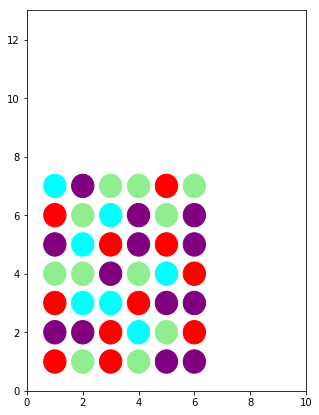

In [188]:
fig, ax = plt.subplots(figsize=(5, 7))

ax.set_xlim((0, 10))
ax.set_ylim((0, 13))

circles = []

for ii in range(7):
    for jj in range(6):
        if (pic[ii, jj, 0] == 1):
            clr = "red"
        elif (pic[ii, jj, 1] == 1):
            clr = "lightgreen"
        elif (pic[ii, jj, 2] == 1):
            clr = "cyan"
        else:
            clr = "purple"
        
        circles.append( plt.Circle((jj + 1, 7 - ii), 0.4, color=clr) )

for circ in circles:
    ax.add_artist(circ)

In [189]:
padded = np.zeros((9, 8, 4))
padded[1:8, 1:7, :] = pic

In [190]:
for layer in aero_cnn.layers:
    if (layer.name == "conv0"):
        lst = layer.get_weights()
        break
        
filters = lst[0]

In [199]:
filt = filters[:, :, :, 6]

result = np.zeros((7, 6))

for ii in range(7):
    for jj in range(6):
        cut = padded[ii:ii+3, jj:jj+3 , :]
        result[ii, jj] = np.round(np.sum(np.multiply(cut, filt)), 4)
        
result.reshape(7, 6)

array([[-0.0244, -0.8073, -0.539 ,  0.0028, -0.6053, -0.1991],
       [-0.6013, -0.1012,  0.1   , -0.3483, -0.4766, -0.2082],
       [-0.7524, -0.2067, -0.7808, -0.0785, -0.4087, -0.1699],
       [-0.3141, -0.4357, -0.9095, -0.1491, -1.1048,  0.0053],
       [-0.1835, -0.4337,  0.1794, -0.482 , -0.2608, -0.2965],
       [-0.4604, -0.195 ,  0.0142, -1.6792, -0.7225, -0.0251],
       [-0.6835,  0.0386, -0.5734,  0.0364,  0.0818, -0.4982]])

### Визуализация и предсказание

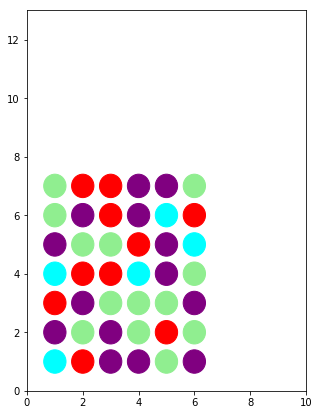

In [71]:
pic = change_two_plates(replay_memory[-2][0], 1)
#pic = replay_memory[-2][0]

fig, ax = plt.subplots(figsize=(5, 7))

ax.set_xlim((0, 10))
ax.set_ylim((0, 13))

circles = []

for ii in range(7):
    for jj in range(6):
        if (pic[ii, jj, 0] > 0):
            clr = "red"
        elif (pic[ii, jj, 1] > 0):
            clr = "lightgreen"
        elif (pic[ii, jj, 2] > 0):
            clr = "cyan"
        else:
            clr = "purple"
        
        circles.append( plt.Circle((jj + 1, 7 - ii), 0.4, color=clr) )

for circ in circles:
    ax.add_artist(circ)

### Что предсказывает сеть, которую хорошо обучили на малом наборе данных

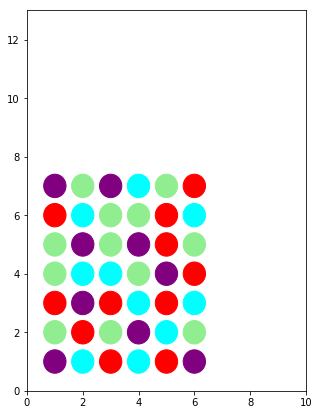

In [8]:
pic = replay_memory[-1][0]

fig, ax = plt.subplots(figsize=(5, 7))

ax.set_xlim((0, 10))
ax.set_ylim((0, 13))

circles = []

for ii in range(7):
    for jj in range(6):
        if (pic[ii, jj, 0] > 0):
            clr = "red"
        elif (pic[ii, jj, 1] > 0):
            clr = "lightgreen"
        elif (pic[ii, jj, 2] > 0):
            clr = "cyan"
        else:
            clr = "purple"
        
        circles.append( plt.Circle((jj + 1, 7 - ii), 0.4, color=clr) )

for circ in circles:
    ax.add_artist(circ)

In [17]:
process_move_142(75)

(3, 1, 'right')

In [19]:
scores = {}

for ii in range(number_of_moves):
    move = ii + 1
    plates = np.array(pic)
    swapped = swap_two_plates(plates, move)
    predicted_score = aero_cnn.predict( np.expand_dims(plates, axis=0) )
    scores[move] = predicted_score
    
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

i = 1
for x in sorted_scores:
    move = x[0]
    print(x[1], process_move_142(x[0]))


[[ 7.22472191]] (2, 2, 'down')
[[ 7.22472191]] (3, 2, 'up')
[[ 6.83188534]] (1, 3, 'right')
[[ 6.83188534]] (1, 4, 'left')
[[ 6.77806902]] (3, 1, 'right')
[[ 6.77806902]] (3, 2, 'left')
[[ 6.70308304]] (3, 2, 'right')
[[ 6.70308304]] (3, 3, 'left')
[[ 6.66363668]] (3, 2, 'down')
[[ 6.66363668]] (4, 2, 'up')
[[ 6.53948545]] (1, 2, 'down')
[[ 6.53948545]] (2, 2, 'up')
[[ 6.37867308]] (2, 2, 'right')
[[ 6.37867308]] (2, 3, 'left')
[[ 6.35099888]] (2, 4, 'down')
[[ 6.35099888]] (3, 4, 'up')
[[ 6.07423162]] (1, 3, 'down')
[[ 6.07423162]] (2, 3, 'up')
[[ 6.04082537]] (3, 4, 'down')
[[ 6.04082537]] (4, 4, 'up')
[[ 5.84908867]] (3, 3, 'right')
[[ 5.84908867]] (3, 4, 'left')
[[ 5.62413788]] (3, 3, 'down')
[[ 5.62413788]] (4, 3, 'up')
[[ 5.5045476]] (2, 1, 'right')
[[ 5.5045476]] (2, 2, 'left')
[[ 5.16240025]] (3, 5, 'right')
[[ 5.16240025]] (3, 6, 'left')
[[ 4.78361845]] (7, 5, 'right')
[[ 4.78361845]] (7, 6, 'left')
[[ 4.65144253]] (2, 5, 'right')
[[ 4.65144253]] (2, 6, 'left')
[[ 4.6345005]] 